# Predicting Retail Customer Churn

## Topic

This project aims to predict customer churn for a typical e-commerce site. The analysis involves aggregating detailed transactional data into meaningful customer-level features, such as purchase frequency, brand loyalty, and product category preferences, to determine which customers are likely to churn. For the purpose of this project, churn is defined as whether an existing customer had made a purchase within 90 days of a cutoff date. The data is sourced from a store that sells skateboard products. Skateboard culture is constantly changing, which leads to varying levels of customer engagement and interest in particular sets of brands. The analysis undertaken here aims to provide insight into which aspects of customer behavior are most likely to result in repeat purchases.

### Type of Learning

Supervised - we know the churn status of the customer.

### Type of Task:

Binary classification - the customer either churned (1) or did not (0).

### Goal

The goal is to understand what factors and behaviors lead to churn, so that we can identify at-risk customers ahead of time. Having this information allows a company to optimize their retention strategies, which leads to stronger customer loyalty and a better long-term relationship between the company and customer.

### GitHub Link:

http://github.com/chande/ml-final

## Data

In [569]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score


df = pd.read_csv('customer_data_hardware_split.csv') 

I created the dataset manually by querying a SQL database, with permission, from a company that I work with. It is a collection of customer purchase data between January 1, 2022, and December 31, 2023. It contains the following customer and purchase attributes:

In [570]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   OnlineCustomerID            3204 non-null   int64  
 1   State                       3203 non-null   object 
 2   total_orders                3204 non-null   int64  
 3   lifetime_spend              3204 non-null   float64
 4   avg_order_value             3204 non-null   float64
 5   total_coupons               3204 non-null   int64  
 6   total_returns               3204 non-null   int64  
 7   days_since_first_purchase   3204 non-null   int64  
 8   days_since_last_purchase    3204 non-null   int64  
 9   avg_days_between_purchases  3204 non-null   float64
 10  customer_tenure             3204 non-null   int64  
 11  deck_count                  3204 non-null   int64  
 12  wheel_count                 3204 non-null   int64  
 13  truck_count                 3204 

Important notes about the data:

- We do not have customer age, which would likely be useful for this type of analysis.
- `lifetime_spend` is reflective of the analysis window of 1/1/2022 - 12/31-2023.
- `customer_tenure` is defined as *days_since_first_purchase - days_since_last_purchase*
- `deck_count`, `wheel_count`, `truck_count`, `bearing_count`, `complete_skateboard_count`, `shoes_count`, `clothing_count` indicate how many items in this customer's orders fall into the respective skate, shoe, or clothing categories, with overlap (meaning a single order can contain zero or more items from any individual category). These are the main umbrella categories that skate shops sell, and different kinds of customers buy items from different categories at different intervals.
- `favorite_brand` is the brand the customer most often purchased.
- `brand_loyalty` is defined as the number of purchases of the customer's `favorite_brand`/ all different brand purchases. A value of 1.0 means that the customer only bought their favorite brand, and no others. A value of .5 means that half of the time, the customer ordered their favorite brand.
- `specialty item` indicates that the customer has participated in the purchase of at least one limited edition specialty item. These items are not generally available to the public, and instead work on a raffle system. It is an interesting field for this analysis because some customers only shop at the store to participate in these events, and do not purchase otherwise.
- `churn` is defined as the customer having a `days_since_last_purchase` >= 180 (or, six months since the last purchase) and a `days_since_first_purchase` >= 180 (meaning the first purchase was more than six months ago). This indicates that the customer has stopped purchasing from the store.

In [571]:
df.describe()

,OnlineCustomerID,total_orders,lifetime_spend,avg_order_value,total_coupons,total_returns,days_since_first_purchase,days_since_last_purchase,avg_days_between_purchases,customer_tenure,deck_count,wheel_count,truck_count,bearing_count,complete_skateboard_count,shoes_count,clothing_count,brand_loyalty,specialty_item,churn
count,3.204000e+03,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000
mean,2.524960e+06,3.225655,350.986768,106.353039,0.884519,0.032147,501.329276,237.551498,155.037281,263.777778,0.685081,0.304931,0.197878,0.162609,0.009988,2.152934,0.779338,0.570510,0.092385,0.550562
std,6.308130e+05,2.516127,379.951250,67.324980,1.871894,0.213272,164.158876,184.626508,139.245833,200.152754,1.745003,1.103323,0.596730,0.544114,0.131848,3.454312,1.794726,0.301959,0.289613,0.497515
min,1.117000e+04,2.000000,26.875000,13.437500,0.000000,0.000000,180.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000
25%,2.221552e+06,2.000000,164.900000,73.318750,0.000000,0.000000,360.000000,79.000000,48.000000,82.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
50%,2.820770e+06,2.000000,246.710000,93.917900,0.000000,0.000000,525.000000,203.000000,117.416667,243.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.500000,0.000000,1.000000
75%,2.963145e+06,3.000000,386.357500,123.340000,1.000000,0.000000,650.000000,354.000000,226.000000,406.250000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000
max,3.146480e+06,42.000000,6043.090000,1578.500000,32.000000,4.000000,729.000000,718.000000,715.000000,715.000000,37.000000,35.000000,11.000000,15.000000,4.000000,93.000000,20.000000,1.000000,1.000000,1.000000


## Data Cleaning and Exploratory Data Analysis

_Disclaimer about the data: since I gathered the data myself by querying the underlying database directly, many of the issue I would have otherwise encountered at this point have already been taken care of. For example, null values have been converted to `0` where appropriate, data types are mostly uniform due to the database structure, and I have omitted customers with less than two orders._

### Data Munging

From the output of `df.info()`, we see that the majority of the columns, except for `State` and `favorite_brand` are numeric. As a safety precaution, we will explicitly convert them to `string`. We also see that there is a null value for `State`, which we will remove along with anything that becomes null as a result of our data type conversion.

In [572]:
#convert columns to string
df['State'] = df['State'].astype('string')
df['favorite_brand'] = df['favorite_brand'].astype('string')

#### Cleaning Problematic Data

In [573]:
#drop null
print(f"columns with missing data before: \n{df.columns[df.isna().any()].tolist()}")
df = df.dropna()
print(f"columns with missing data after: \n{df.columns[df.isna().any()].tolist()}")

columns with missing data before: 
['State']
columns with missing data after: 
[]


Now we can take another look at these columns. Because of inconsistent validation at the source, there are values for `State` which do not follow the standard two-letter abbreviation that most records use. 

In [574]:
#drop states whose label is longer than two characters
print(f"Number of invalid state rows before: {len(df.loc[df['State'].str.len() > 2, 'State'])}")
df = df.loc[df['State'].astype('string').str.len().le(2)]
print(f"Number of invalid state rows after: {len(df.loc[df['State'].str.len() > 2, 'State'])}")

Number of invalid state rows before: 84
Number of invalid state rows after: 0


### Dropping 

We can also drop the `OnlineCustomerID` column, as well as redundant columns such as `days_since_first_purchase` and `days_since_last_purchase`, since the information they convey is stored in `customer_tenure`, `avg_days_between_purchases`, and `churn`.

In [575]:
#drop redundant columns
df = df.drop(columns = ['OnlineCustomerID', 'days_since_first_purchase', 'days_since_last_purchase'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3119 entries, 0 to 3203
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   State                       3119 non-null   string 
 1   total_orders                3119 non-null   int64  
 2   lifetime_spend              3119 non-null   float64
 3   avg_order_value             3119 non-null   float64
 4   total_coupons               3119 non-null   int64  
 5   total_returns               3119 non-null   int64  
 6   avg_days_between_purchases  3119 non-null   float64
 7   customer_tenure             3119 non-null   int64  
 8   deck_count                  3119 non-null   int64  
 9   wheel_count                 3119 non-null   int64  
 10  truck_count                 3119 non-null   int64  
 11  bearing_count               3119 non-null   int64  
 12  complete_skateboard_count   3119 non-null   int64  
 13  shoes_count                 3119 non-n

### Class imbalance

Text(0.5, 1.0, 'Overall churn rate')

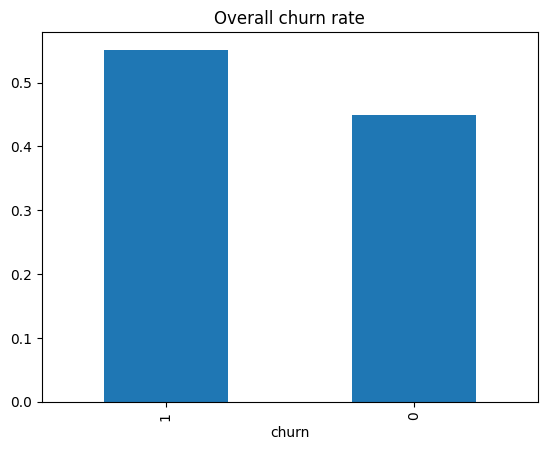

In [576]:
#count churn values
df['churn'].value_counts(normalize=True).plot(kind='bar')
plt.title('Overall churn rate')

We see that the data is well balanced, so we will not introduce any sophisticated sampling or class weighting techniques.

### Visualizing the data

We begin by separating the categorical and numeric columns. In this case only `State` and `favorite_brand` use string data, where `specialty_item` is a binary value indicating whether the customer had ever purchased a specialty item. The rest of the values are numeric.

In [577]:
#separate categorical and numeric values
cat_cols  = ['State', 'favorite_brand', 'specialty_item']
num_cols  = df.select_dtypes(['int64','float64']).columns.difference(['churn', 'specialty_item'])
target = 'churn'

#### Numerical Columns Histogram

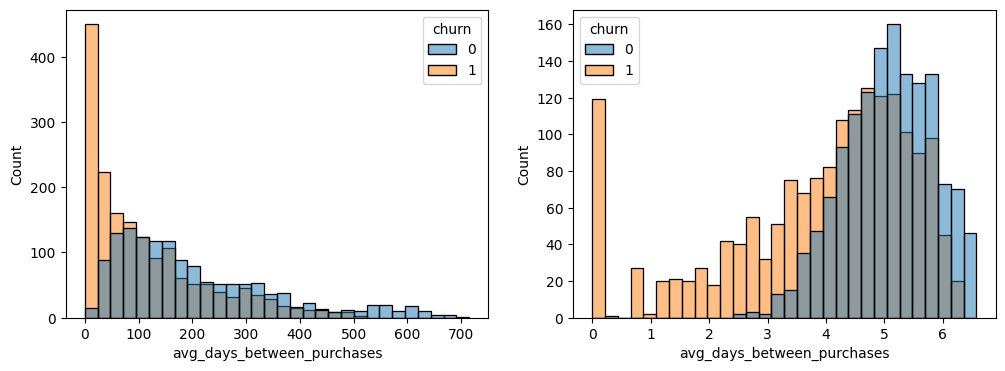

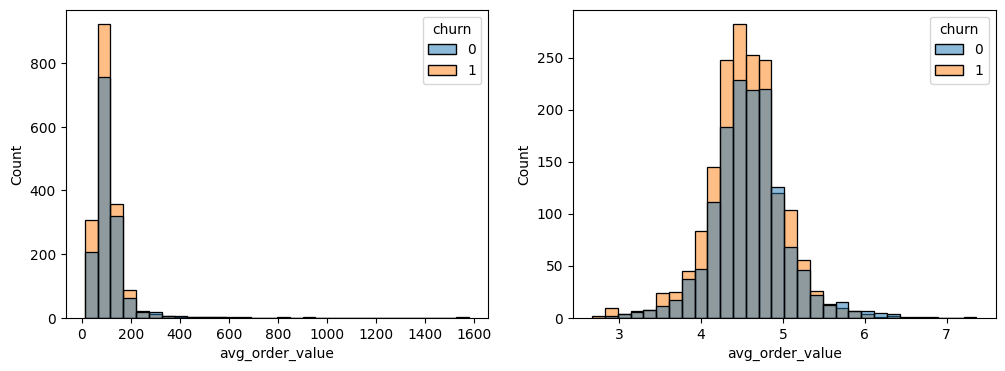

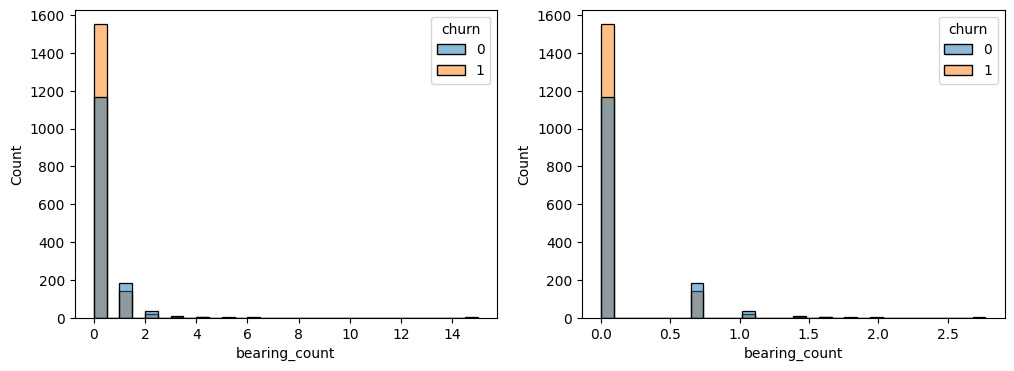

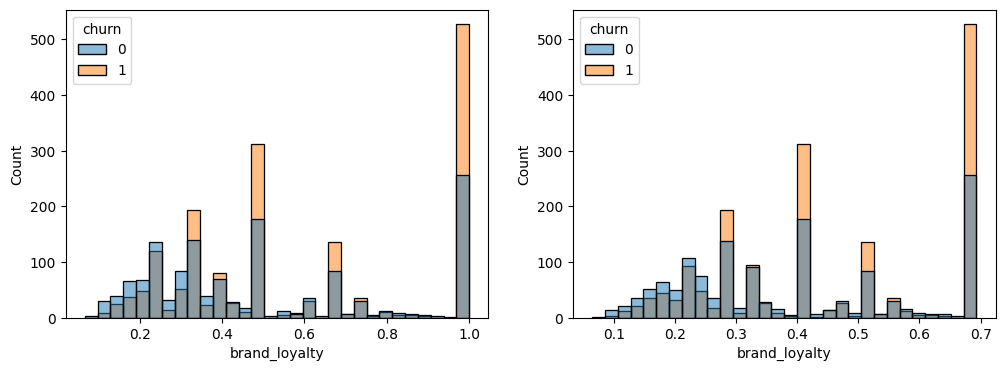

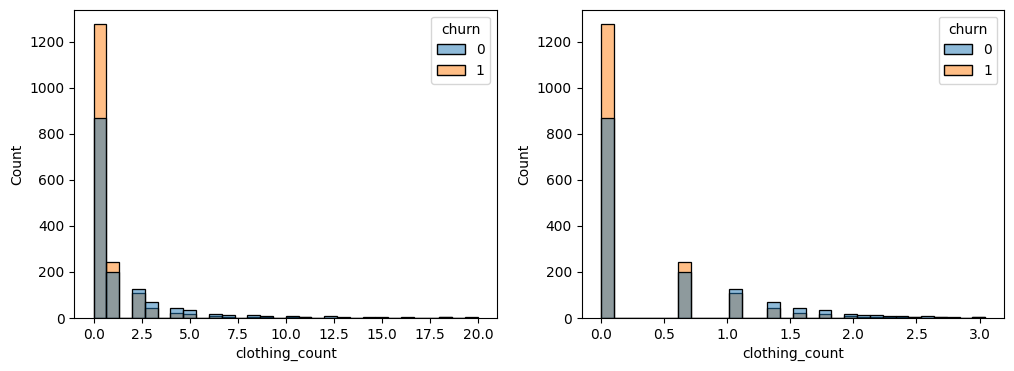

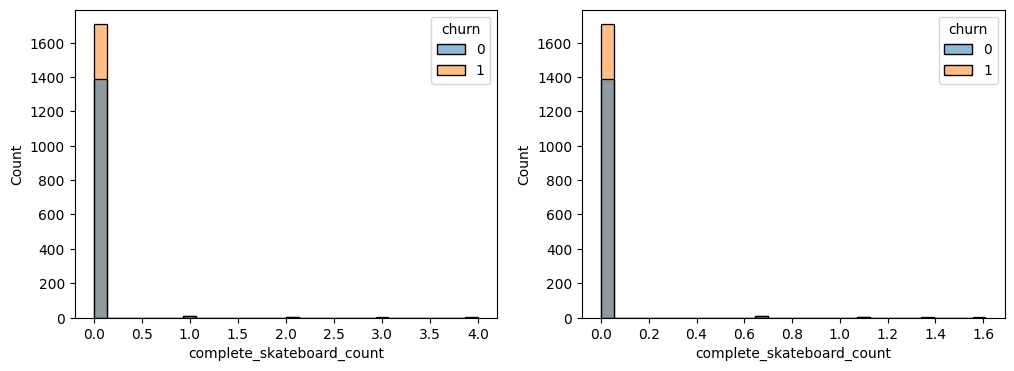

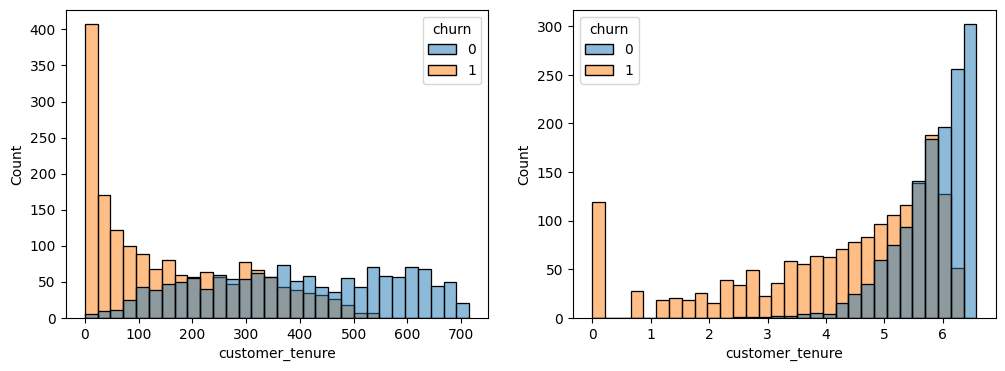

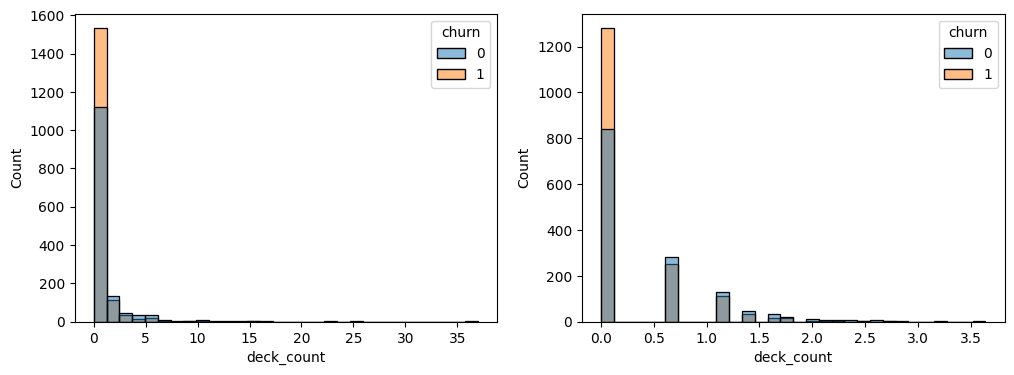

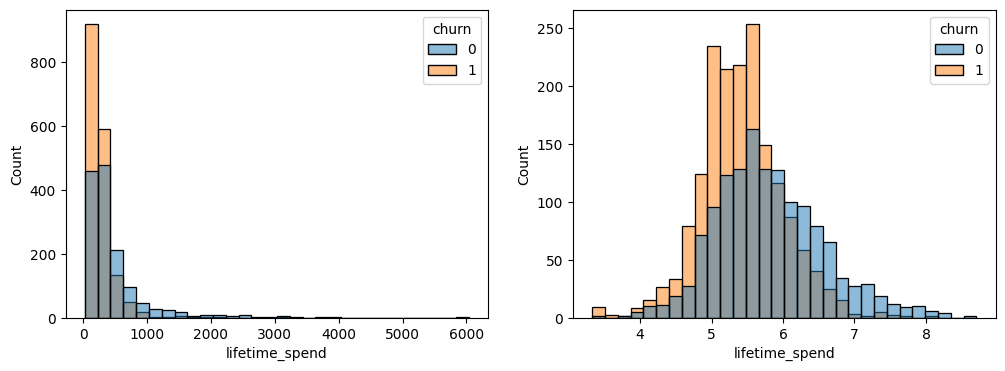

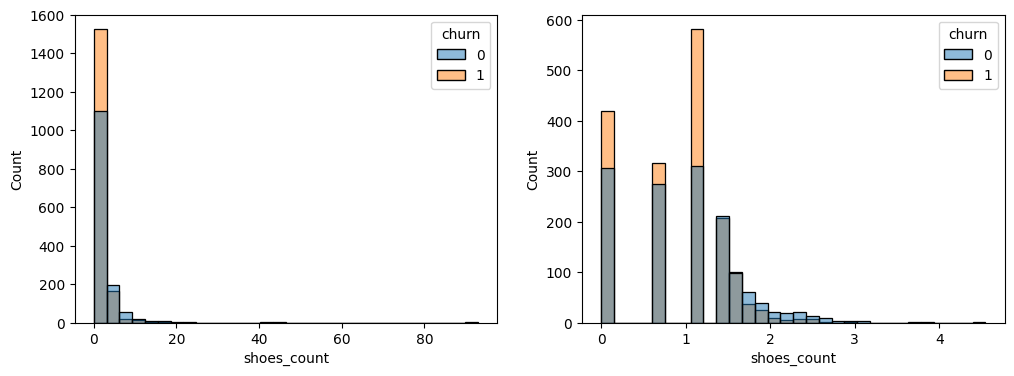

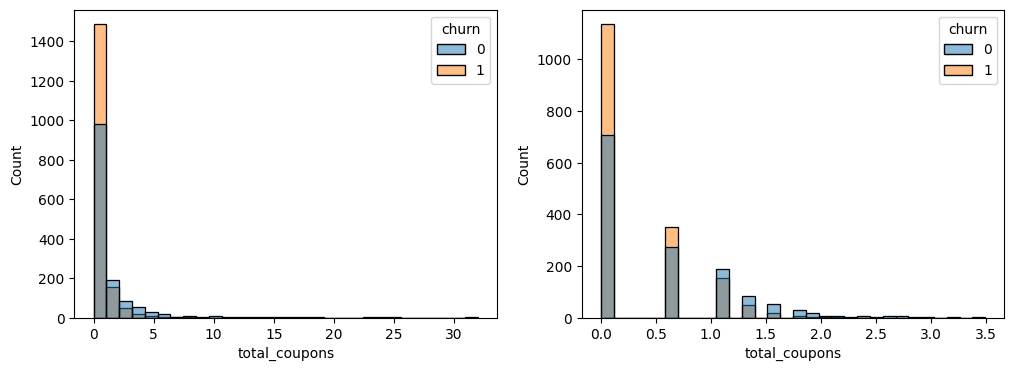

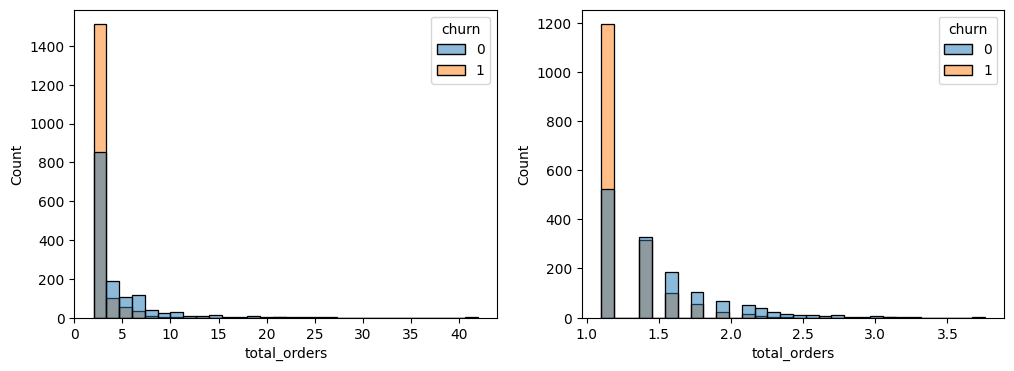

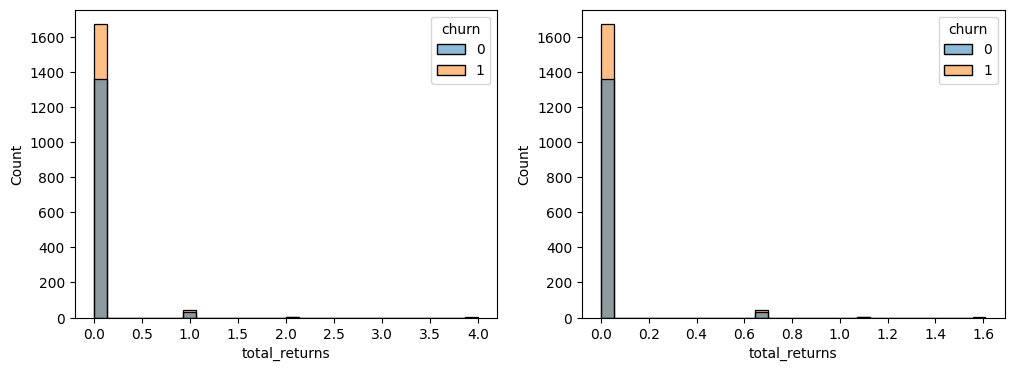

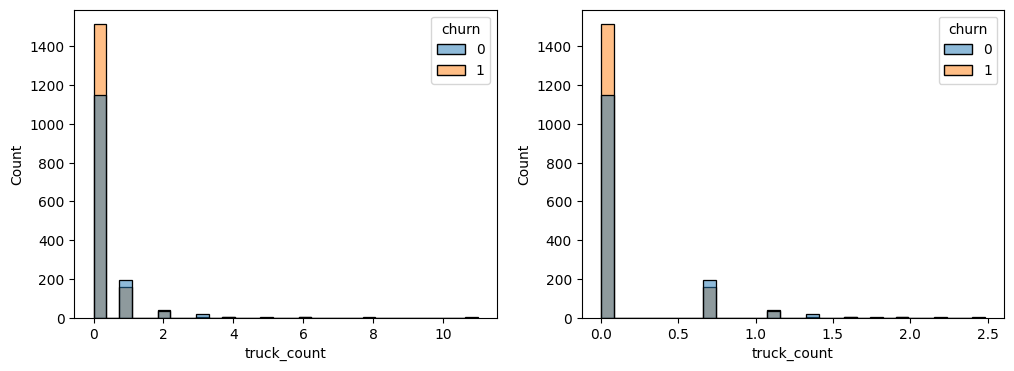

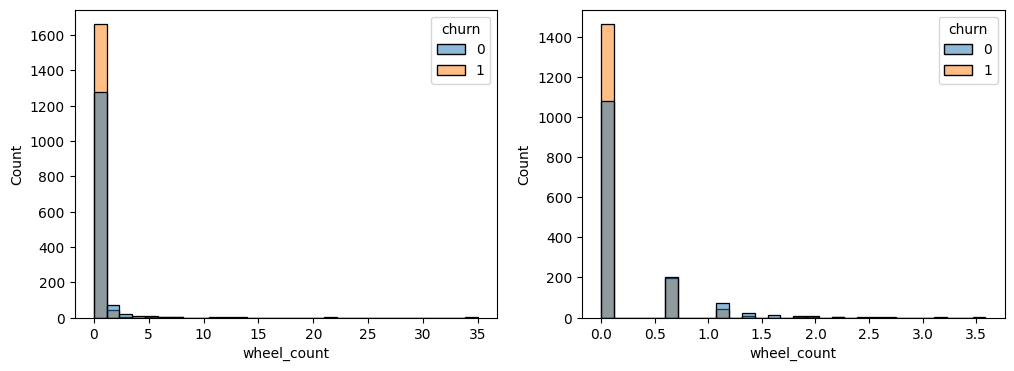

In [578]:
#create histogram for each numeric column
for feature in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # sns.histplot(data=df, x=feature, hue='churn', log_scale=False, common_norm=False, bins=30, ax=ax[0])
    # sns.histplot(data=df, x=feature, hue='churn', log_scale=True, common_norm=False, bins=30, ax=ax[1])
    sns.histplot(data=df, x=feature, hue='churn', common_norm=False, bins=30, ax=ax[0])
    sns.histplot(data=df, x=np.log1p(df[feature]), hue='churn', common_norm=False, bins=30, ax=ax[1])
    plt.show()

Some interesting insights:

- We see that `lifetime_spend`, `avg_order_value`, and `avg_days_between_purchases` are highly right-skewed, and benefit from log transformation. We will apply this when we start creating models.
- `avg_order_value` vs. `lifetime_spend`: average order value does not seem to weigh heavily (although we see slightly less churn with higher averages), but it is clear that the customers who have spent the most during their e are least likely to churn.
- `brand_loyalty`: customers with near-perfect or 50/50 split brand loyalty are most likely to churn. It is customers with a wider range of brand purchases who are less likely to churn.
- `skate_count` vs. `clothing_count` vs. `shoe_count`: customers who purchase more skate items or clothing are less likely to churn compared to customers who only purchase shoes.
- `total_coupons`: customers who use more coupons are less likely to churn. Many customers get a one-time coupon incentive upon account creation, which is likely why we see so many singe-use customers churning.

#### Percent Churn by categorical columns

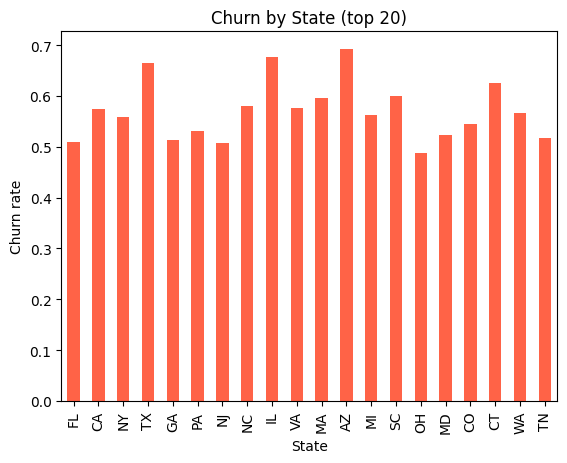

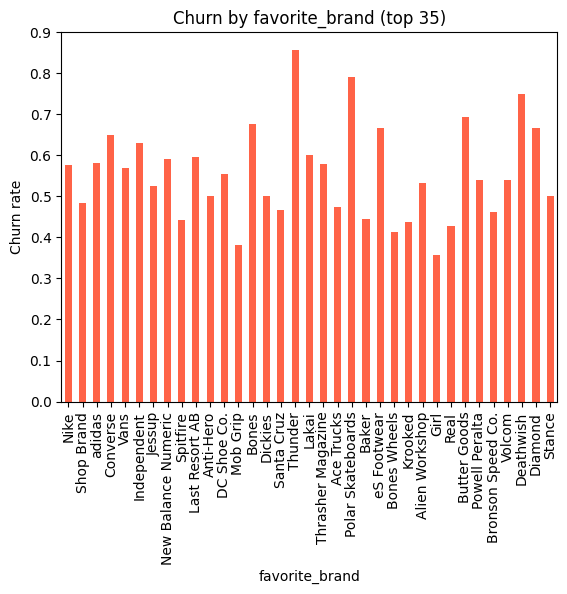

In [579]:
#create bar chart for categorical values
def bar_churn(col, top_n=15):
    tmp = ( df.groupby(col)[target]
              .agg(['count','mean'])
              .sort_values('count', ascending=False)
              .head(top_n) )
    tmp['mean'].plot(kind='bar', color='tomato', ylabel='Churn rate')
    plt.title(f'Churn by {col} (top {top_n})')
    plt.show()

bar_churn('State', 20)
bar_churn('favorite_brand', 35)

Churn by categorical values reveals some interesting trends.

- `state`: We see that the states least likely to churn are closer to the east coast, where states farther to the west (TX, AZ) are more likely to churn. An exception in this case is California, which is expected due to the disproportionately large number of skateboarders there compared to other states. This could be due to longer shipping times for items that need to go across the country - inventory is shipped from Florida, which is where the most orders go and which has the one of the lowest churn rates.
- `favorite_brand`: The brands least likely to be related to churn (less than .5) are ones that sell skateboard hardware and have less of a coherent "image." They sell items like wheels, bearings, and trucks, that all skateboarders need to use.

#### Correlation Matrix

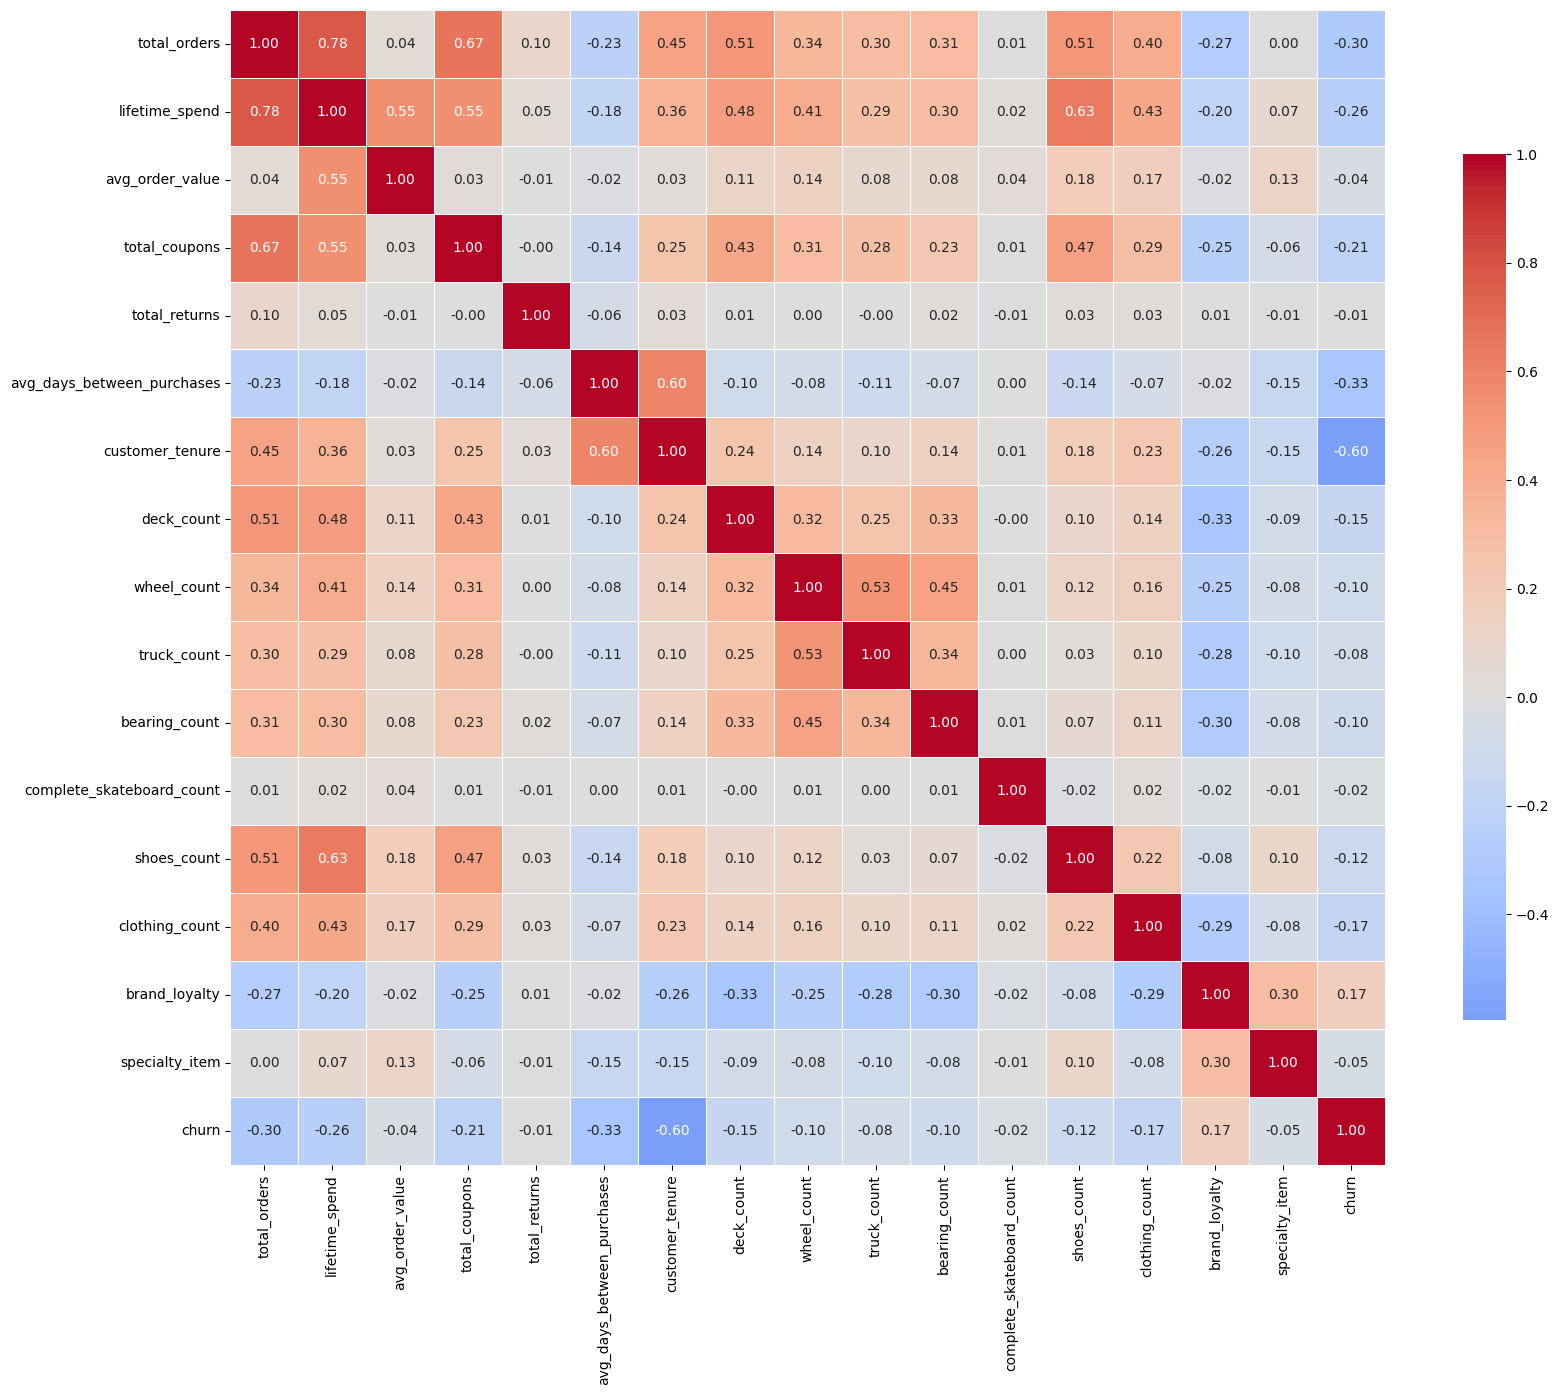

In [580]:
num_cols  = df.select_dtypes(['int64','float64']).columns
plt.figure(figsize=(20, 15))
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}
)
num_cols  = df.select_dtypes(['int64','float64']).columns.difference(['churn', 'specialty_item'])

Analysis:

- `customer_tenure` vs. `avg_days_between_purchases`: as customers stick with the company for longer, the average days between purchases grows.
- `lifetime_spend`: highly correlated with `total_orders`, which is natural, but suprisingly second most highly correlated with pairs of shoes purchased, followed by `total_coupons`. This indicates that the people who have spent the most over time have also received many discounts.
- `brand_loyalty`: negatively correlated with skate brands. This makes sense because skateboards are naturally composed of pieces from different brands. It is very uncommon for companies to sell skateboard products from different categories.
- `total_returns` and `complete_skateboard_count` are not strongly correlated with anything.

## Models and Analysis

We previously saw that `lifetime_spend`, `avg_order_value`, and `avg_days_between_purchases` are highly right-skewed. We will log-transform them to make them more symmetric.

In [581]:
#log transform skewed features
skewed = ['lifetime_spend', 'avg_order_value',
          'avg_days_between_purchases']
for c in skewed:
    df[c + '_log'] = np.log1p(df[c])
df = df.drop(columns=['lifetime_spend', 'avg_order_value',
          'avg_days_between_purchases'])

We have two categorical features which will benefit from encoding: `State`, and `favorite_brand`.

In [582]:
#encode categorical features
cat_cols = ['State', 'favorite_brand']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

We proceed to create three models: Decision Tree, Random Forest, and Gradient Boost as they are well-suited to this type of categorization task. 

In [583]:
models = {
    'Decision Tree'   : DecisionTreeClassifier(random_state=42),
    'Random Forest'   : RandomForestClassifier(
                           n_estimators=300, class_weight='balanced', n_jobs=-1,
                           random_state=42),
    'Gradient Boost'  : GradientBoostingClassifier(
                           n_estimators=600, learning_rate=0.03,
                           max_depth=3, random_state=42)
}

With the columns transformed, we can proceed to run the models.

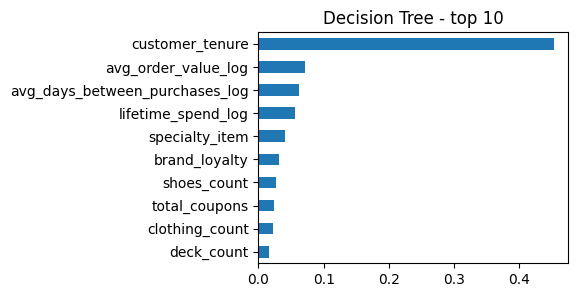

Decision Tree
  AUC      : 0.736
  Accuracy : 0.738
  Recall   : 0.763


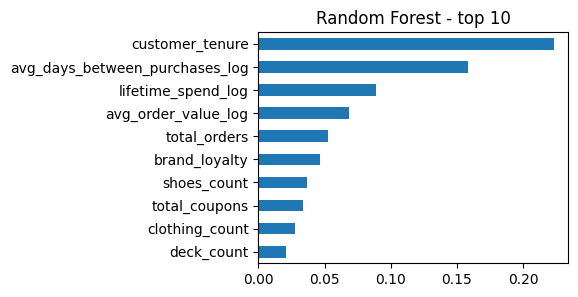

Random Forest
  AUC      : 0.860
  Accuracy : 0.755
  Recall   : 0.812


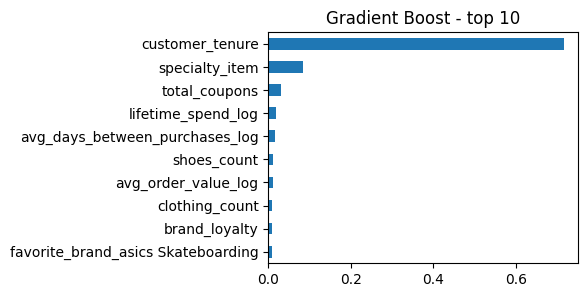

Gradient Boost
  AUC      : 0.863
  Accuracy : 0.768
  Recall   : 0.837


<Figure size 640x480 with 0 Axes>

In [584]:
def print_models(X_train, y_train, X_test, y_test):     
    for name, clf in models.items():
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot([0, 1], [0, 1])    

        clf.fit(X_train, y_train)

        proba   = clf.predict_proba(X_test)[:, 1]
        y_pred  = (proba >= 0.5).astype(int)

        auc     = roc_auc_score(y_test, proba)
        acc     = accuracy_score(y_test, y_pred)
        rec     = recall_score(y_test, y_pred)

        #feature importance
        ax.cla()     
        imp = (pd.Series(clf.feature_importances_, index=X.columns)
                    .sort_values(ascending=False))
        imp.head(10).plot.barh(title=f'{name} - top 10', figsize=(4,3))
        plt.gca().invert_yaxis(); plt.show()

        print(f'{name}')
        print(f'  AUC      : {auc:.3f}')
        print(f'  Accuracy : {acc:.3f}')
        print(f'  Recall   : {rec:.3f}')

    plt.tight_layout()
    plt.show()

X = df_encoded.drop(columns=['churn'])
y = df_encoded['churn']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42)

print_models(X_train, y_train, X_test, y_test)    

In all cases, `customer_tenure` is the most important feature. This indicates that tenure provides the strongest signal the model uses to separate churners from non-churners. From a business perspective, this could motivate marketing efforts towards customers who have churned in the past year but also had a high tenure. Looking at the scores, we see that Random Forest and Gradient Boost have similar scores, and both outperform the single Decision Tree.

We see that Gradient boost performs the best overall, with an AUC score of .863. In an attempt to improve this score, we will use cross-validation with randomized search to tune the parameters:

In [585]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators' : np.arange(300, 1501, 100),
    'learning_rate': np.linspace(0.01, 0.15, 15),
    'max_depth'    : [2, 3, 4],
    'min_samples_leaf': [1, 5, 10, 25],
    'subsample'    : [0.6, 0.7, 0.8, 0.9]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
            gb, param_dist, n_iter=60, scoring='roc_auc',
            cv=cv, n_jobs=-1, random_state=42, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


339131.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339131.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339131.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339131.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
339132.07s - pydevd: Sending m

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15]),
                                        'max_depth': [2, 3, 4],
                                        'min_samples_leaf': [1, 5, 10, 25],
                                        'n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200, 1300,
       1400, 1500]),
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=42, scoring='roc_auc', verbose=1)

  AUC      : 0.869
  Accuracy : 0.772
  Recall   : 0.837
  Best params: {'subsample': 0.7, 'n_estimators': 1100, 'min_samples_leaf': 25, 'max_depth': 2, 'learning_rate': 0.01}


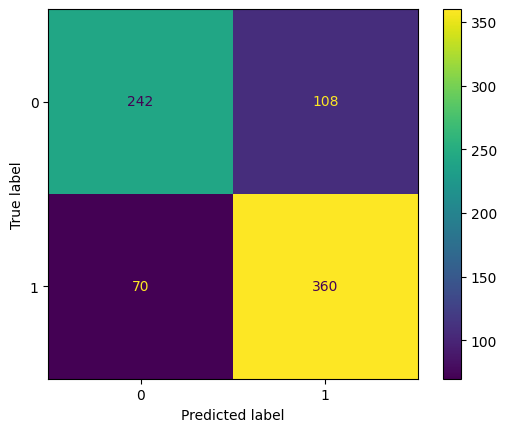

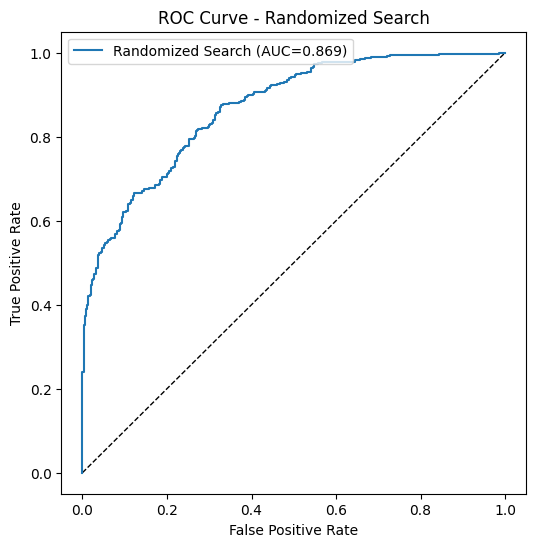

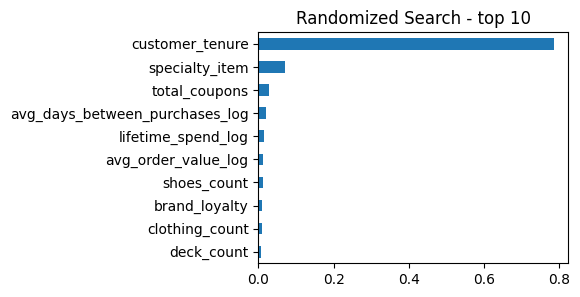

In [586]:
proba   = search.predict_proba(X_test)[:, 1]
y_pred  = (proba >= 0.5).astype(int)

auc     = roc_auc_score(y_test, proba)
acc     = accuracy_score(y_test, y_pred)
rec     = recall_score(y_test, y_pred)

print(f'  AUC      : {auc:.3f}')
print(f'  Accuracy : {acc:.3f}')
print(f'  Recall   : {rec:.3f}')
print(f'  Best params: {search.best_params_}')

conf=confusion_matrix(y_test,y_pred)
plot=ConfusionMatrixDisplay(confusion_matrix=conf)
plot.plot()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))        # one ROC figure for everybody
ax.plot([0, 1], [0, 1], 'k--', lw=1) 

fpr, tpr, _ = roc_curve(y_test, proba)
ax.plot(fpr, tpr, lw=1.5, label=f'Randomized Search (AUC={auc:.3f})')
ax.set_title('ROC Curve - Randomized Search')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# draw the legend
ax.legend(loc='upper left')   
plt.show()

imp = (pd.Series(search.best_estimator_.feature_importances_, index=X.columns)
            .sort_values(ascending=False))
imp.head(10).plot.barh(title=f'Randomized Search - top 10', figsize=(4,3))
plt.gca().invert_yaxis(); plt.show()

We see that the Randomized Search model results in a _slightly_ better AUC with `0.869` over Gradient Boost's `0.863`, and that the important features are mostly the same.

## Discussion and Conclusion

In this notebook, we looked at data for a skateboarding e-commerce website and trained models to predict customer churn. The data was compiled by manually writing SQL queries against the company's database.

While performing Exploratory Data Analysis, we found that there was a roughly 55/45 split in classes between the majority and minority classes, with most customers having churned. When we looked at histograms of the data, we saw some fields right-skewed, and decided to log-transform the data to account for that. The log-transformed values were used in our final models, and the original columns were dropped. We also examined the top drivers of categorical values, which would likely be of use on its own to make business decisions. Finally, we examined a heatmap and found that some values are highly correlated.

We trained four models on the data: a Decision Tree, Random Forest, Gradient Boost Classifier, and Gradient Boost using Random Search Cross-Validation. We saw that the Random Forest and Gradient Boost classifiers performed better than the single decision tree, and when we added cross-validation to tune the hyperparameters, we saw a slight gain in improvement.

The best AUC achieved was `0.869` by the Gradient Boost with Random Search Cross-Validation. In this model, as well as the others, `customer_tenure` was shown to be the most important feature.

#### Takeaways
- Tenure, if it can be nurtered, is extremely important in retaining customers. This seems self-fulfilling, but what we see in the data, counterintuitively, is that the longer a customer goes between purchases, the less likely they are to churn. From a business perspective, this can mean finding customers who have been with the company a long time but who have not purchased in a while, and offering some sort of purchase incentive.
- Low brand loyalty is also counterintuitively a good indicator of a churned customer. Customers who are more loyal to a single brand churn more often. This could indicate that more effort should be done to suggest a variety of brands during the shopping experience.

#### Improvements
- We had a large enough number of rows for the task to be meaningful, but could have benefited from a larger number of features that included more details demographic information.
- Some features were highly correlated and should have been dropped altogether or engineered out. One problem that we faced here was that a lot of the time values included some natural correlation - as number of orders goes up, tenure naturally goes up, as well as lifetime spend. These may not impart as much real-world insight as we would like.
- We see that accuracy is about 75% across all models, indicating that there may have been more of an imbalance than we originally thought. It would be better to address this class imbalance in the future.